In [1]:
import pandas as pd

import shap
shap.initjs()

shuffle = True

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
file_url = r"C:\Users\tzuli\Documents\python\ChuanMai\data\raw\eda.csv"
df = pd.read_csv(file_url)

In [3]:
df = df.drop(["order_id", "cabinet", "item_name", "color", "e_ship_date"], axis = 1)
df = df.iloc[:1000]
df.head(3)

,label,length,width,area,area_prob,waste,color_num,cabinet_num,color_cabinet_num,color_item_num,item_num,color1_num,cabinet1_num,color_cabinet1_num,color_item1_num,item1_num
0,1,443.0,96.0,42528.0,0.004725,0.995275,0.000768,0.002519,0.047619,1.000000,1.0,1.000000,0.142857,1.0,1.00,1.0
1,0,964.0,96.0,92544.0,0.010283,0.984992,0.001536,0.005038,0.095238,0.052632,0.5,0.027027,0.038462,0.5,0.25,0.5
2,2,964.0,96.0,92544.0,0.010283,0.974709,0.002304,0.007557,0.142857,0.105263,1.0,0.054054,0.076923,1.0,0.50,1.0


In [4]:
features = list(df.columns[1:])
target = "label"

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop(target, axis = 1), df[target], test_size = 0.2, shuffle = shuffle)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(800, 15) (200, 15) (800,) (200,)


In [6]:
outlier_boundary = {}
for col in features:
    Q1   = X_train[col].quantile(0.25)
    Q3   = X_train[col].quantile(0.75)
    IQR  = Q3 - Q1
    min_ = Q1 - (1.5 * IQR)
    max_ = Q3 + (1.5 * IQR)
    
    X_train[col] = X_train[col].apply(lambda X: max_ if X > max_ else X)
    X_train[col] = X_train[col].apply(lambda X: min_ if X < min_ else X)

    X_test[col] = X_test[col].apply(lambda X: max_ if X > max_ else X)
    X_test[col] = X_test[col].apply(lambda X: min_ if X < min_ else X)

    outlier_boundary[col] = {
        "min": min_,
        "max": max_,
    }

In [7]:
from scipy.stats import skew

skewness = X_train[features].apply(lambda X: skew(X)).sort_values(ascending=False)
skewness = pd.DataFrame({'Feature' : skewness.index, 'Skew' : skewness.values})
skewness = skewness.query("(Skew > 0.75) | (Skew < -0.75)")
skewness = skewness.reset_index(drop = True)
skew_feat = skewness["Feature"].to_list()

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.


In [8]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method = 'yeo-johnson')
X_train[skew_feat] = pt.fit_transform(X_train[skew_feat])
X_test[skew_feat] = pt.transform(X_test[skew_feat])

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train[features] = scaler.fit_transform(X_train[features])
X_test[features] = scaler.transform(X_test[features])

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [11]:
num_classes = 5
model = tf.keras.Sequential([
    Dense(128, activation='relu', input_shape=(15,)),         # 第一個隱藏層
    Dense(64, activation='relu'), # 第二個隱藏層
    Dense(num_classes, activation='softmax')  # 輸出層，使用 softmax 進行分類
  ])

In [12]:
# 編譯模型
model.compile(optimizer=Adam(learning_rate=0.001),
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2048      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 5)                 325       
                                                                 
Total params: 10629 (41.52 KB)
Trainable params: 10629 (41.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
model.fit(X_train, y_train, 
         epochs=15, 
         batch_size=128,
         validation_data=(X_test, y_test)
         )

Epoch 1/15
7/7 [==============================] - 1s 24ms/step - loss: 1.4626 - accuracy: 0.4775 - val_loss: 1.1256 - val_accuracy: 0.7850
Epoch 2/15
7/7 [==============================] - 0s 5ms/step - loss: 0.9832 - accuracy: 0.8338 - val_loss: 0.7266 - val_accuracy: 0.8800
Epoch 3/15
7/7 [==============================] - 0s 5ms/step - loss: 0.6902 - accuracy: 0.8450 - val_loss: 0.5062 - val_accuracy: 0.8950
Epoch 4/15
7/7 [==============================] - 0s 5ms/step - loss: 0.5501 - accuracy: 0.8363 - val_loss: 0.4156 - val_accuracy: 0.8950
Epoch 5/15
7/7 [==============================] - 0s 5ms/step - loss: 0.4984 - accuracy: 0.8363 - val_loss: 0.3746 - val_accuracy: 0.8900
Epoch 6/15
7/7 [==============================] - 0s 5ms/step - loss: 0.4619 - accuracy: 0.8500 - val_loss: 0.3564 - val_accuracy: 0.9000
Epoch 7/15
7/7 [==============================] - 0s 5ms/step - loss: 0.4326 - accuracy: 0.8575 - val_loss: 0.3441 - val_accuracy: 0.9100
Epoch 8/15
7/7 [=================

In [15]:
loss, accuracy = model.evaluate(X_test, y_test)

print("Accuracy", accuracy)

7/7 [==============================] - 0s 1ms/step - loss: 0.2875 - accuracy: 0.9050
Accuracy 0.9049999713897705


In [16]:
explainer = shap.KernelExplainer(model, X_train)

Using 800 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [ ]:
shap_values = explainer.shap_values(X_train)

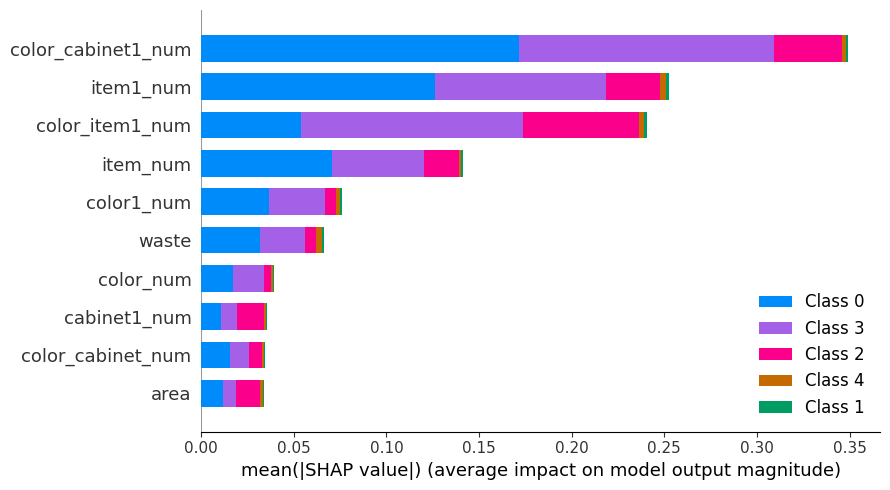

In [18]:
shap.summary_plot(shap_values, X_train, plot_size=(9, 5), max_display = 10, show=True)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


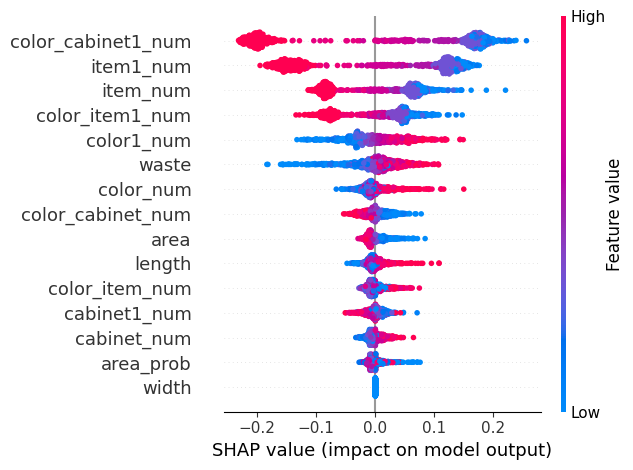

In [19]:
shap.summary_plot(shap_values[0], X_train, plot_size=None, show=False)

In [24]:
shap.force_plot(explainer.expected_value[0], shap_values[0])